# Data Leakage Temporal: La Importancia del Split Correcto

En este notebook exploraremos un error común y peligroso en machine learning: **usar train/test split aleatorio en datos con componente temporal**.

## El Problema

Cuando trabajamos con datos que tienen una dimensión temporal (series de tiempo, transacciones, eventos históricos), hacer un split aleatorio puede causar **data leakage**, donde el modelo "ve el futuro" durante el entrenamiento.

**Resultado**: Métricas optimistas que no reflejan el desempeño real en producción.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración
sns.set_style("whitegrid")
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Generación de Datos Sintéticos: Ventas de Producto

Simulamos ventas diarias de un producto con:
- **Tendencia creciente** a lo largo del tiempo
- **Estacionalidad semanal** (más ventas en fin de semana)
- **Características temporales** que pueden generar leakage

In [2]:
# Generar datos de 2 años (730 días)
n_days = 730
start_date = datetime(2022, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(n_days)]

# Crear DataFrame
df = pd.DataFrame({
    'fecha': dates,
    'dia_numero': range(n_days)
})

# Extraer características temporales
df['dia_semana'] = df['fecha'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['mes'] = df['fecha'].dt.month
df['es_fin_semana'] = (df['dia_semana'] >= 5).astype(int)

# Generar ventas con patrón temporal claro:
# 1. Tendencia creciente
tendencia = 50 + 0.15 * df['dia_numero']

# 2. Estacionalidad semanal (más ventas en fin de semana)
estacionalidad = 20 * df['es_fin_semana']

# 3. Efecto del mes (más ventas en diciembre)
efecto_mes = np.where(df['mes'] == 12, 30, 0)

# 4. Ruido aleatorio
ruido = np.random.normal(0, 10, n_days)

# Ventas totales
df['ventas'] = tendencia + estacionalidad + efecto_mes + ruido
df['ventas'] = df['ventas'].clip(lower=0)  # No puede haber ventas negativas

# Agregar lag features (ventas de días anteriores)
df['ventas_lag_1'] = df['ventas'].shift(1)  # Ventas del día anterior
df['ventas_lag_7'] = df['ventas'].shift(7)  # Ventas de hace una semana
df['ventas_media_7d'] = df['ventas'].shift(1).rolling(window=7).mean()  # Media móvil 7 días

# Eliminar NaNs generados por los lags
df = df.dropna().reset_index(drop=True)

print(f"Dataset generado: {len(df)} días de datos")
print(f"Rango de fechas: {df['fecha'].min().date()} a {df['fecha'].max().date()}")
df.head(10)

Dataset generado: 723 días de datos
Rango de fechas: 2022-01-08 a 2023-12-31


,fecha,dia_numero,dia_semana,mes,es_fin_semana,ventas,ventas_lag_1,ventas_lag_7,ventas_media_7d
0,2022-01-08,7,5,1,1,78.724347,66.692128,74.967142,61.364415
1,2022-01-09,8,6,1,1,66.505256,78.724347,68.767357,61.901159
2,2022-01-10,9,0,1,0,56.775600,66.505256,56.776885,61.578002
3,2022-01-11,10,1,1,0,46.865823,56.775600,65.680299,61.577818
4,2022-01-12,11,2,1,0,46.992702,46.865823,48.258466,58.890036
5,2022-01-13,12,3,1,0,54.219623,46.992702,48.408630,58.709213
6,2022-01-14,13,4,1,0,32.817198,54.219623,66.692128,59.539354
7,2022-01-15,14,5,1,1,54.850822,32.817198,78.724347,54.700079
8,2022-01-16,15,6,1,1,66.627125,54.850822,66.505256,51.289575
9,2022-01-17,16,0,1,0,42.271689,66.627125,56.775600,51.306985


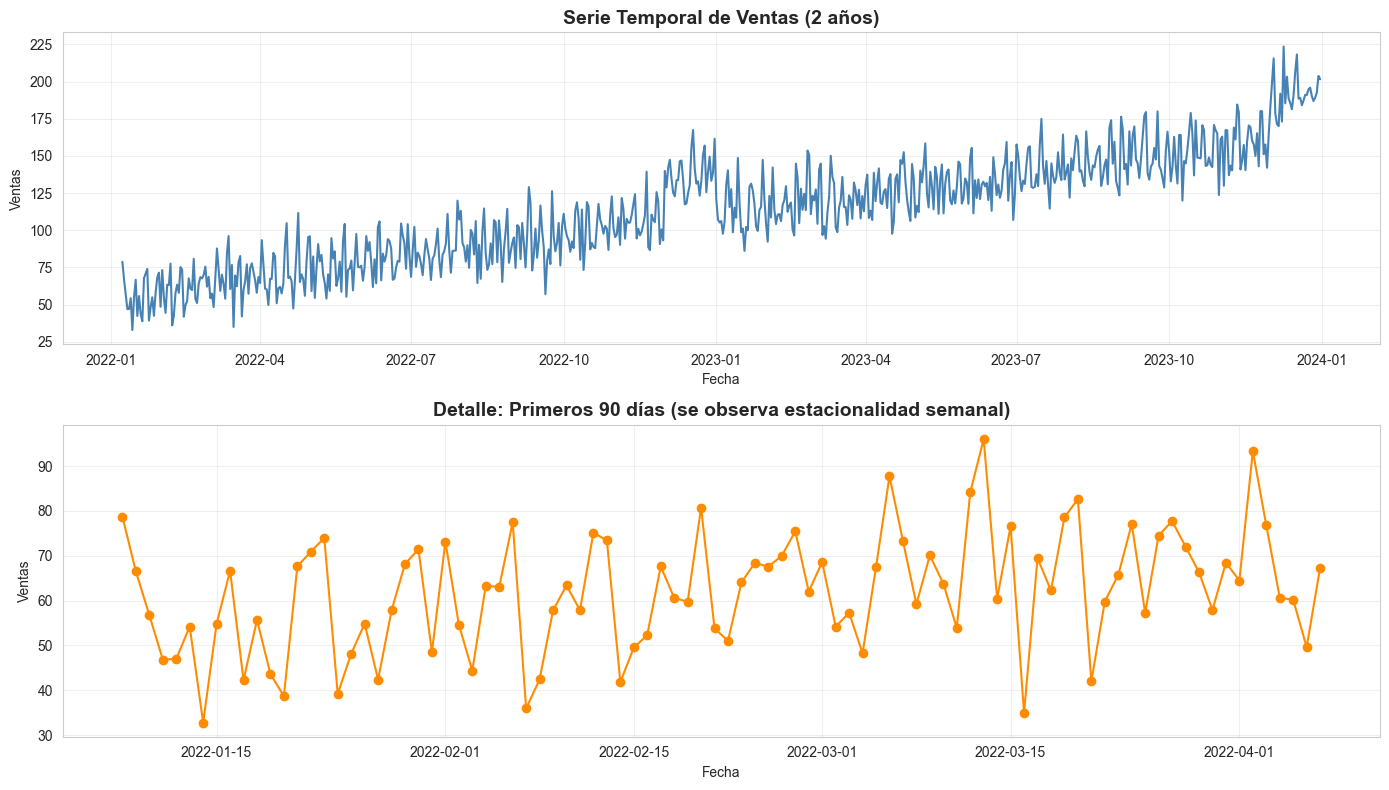


Observa:
- Tendencia creciente a lo largo del tiempo
- Picos recurrentes cada semana (fin de semana)


In [3]:
# Visualizar la serie temporal
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Serie completa
axes[0].plot(df['fecha'], df['ventas'], linewidth=1.5, color='steelblue')
axes[0].set_title('Serie Temporal de Ventas (2 años)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Ventas')
axes[0].grid(True, alpha=0.3)

# Zoom en primeros 90 días para ver estacionalidad semanal
df_zoom = df.head(90)
axes[1].plot(df_zoom['fecha'], df_zoom['ventas'], marker='o', linewidth=1.5, color='darkorange')
axes[1].set_title('Detalle: Primeros 90 días (se observa estacionalidad semanal)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Ventas')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObserva:")
print("- Tendencia creciente a lo largo del tiempo")
print("- Picos recurrentes cada semana (fin de semana)")

## 2. Preparación de Features y Target

Usaremos características temporales y lags para predecir las ventas.

In [4]:
# Definir features y target
features = ['dia_semana', 'mes', 'es_fin_semana', 'dia_numero', 
            'ventas_lag_1', 'ventas_lag_7', 'ventas_media_7d']

X = df[features]
y = df['ventas']

print(f"Features utilizadas: {features}")
print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

Features utilizadas: ['dia_semana', 'mes', 'es_fin_semana', 'dia_numero', 'ventas_lag_1', 'ventas_lag_7', 'ventas_media_7d']

Shape de X: (723, 7)
Shape de y: (723,)


## 3. ❌ Enfoque INCORRECTO: Split Aleatorio

### ¿Por qué es incorrecto?

Al hacer un split aleatorio, mezclamos datos de diferentes períodos:
- Datos de diciembre 2022 pueden estar en **train**
- Datos de enero 2022 pueden estar en **test**

**Problema**: El modelo aprende de datos "futuros" y usa esa información para predecir el "pasado". Esto no refleja la realidad, donde siempre predecimos el futuro basándonos solo en el pasado.

In [5]:
# Split aleatorio (INCORRECTO para datos temporales)
X_train_wrong, X_test_wrong, y_train_wrong, y_test_wrong = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True  # shuffle=True es el problema
)

print("Split Aleatorio (INCORRECTO)")
print("="*50)
print(f"Train: {len(X_train_wrong)} muestras")
print(f"Test:  {len(X_test_wrong)} muestras")

# Entrenar modelo
model_wrong = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
model_wrong.fit(X_train_wrong, y_train_wrong)

# Predicciones
y_pred_wrong = model_wrong.predict(X_test_wrong)

# Métricas
mae_wrong = mean_absolute_error(y_test_wrong, y_pred_wrong)
rmse_wrong = np.sqrt(mean_squared_error(y_test_wrong, y_pred_wrong))
r2_wrong = r2_score(y_test_wrong, y_pred_wrong)

print(f"\nMétricas en Test (Split Aleatorio):")
print(f"  MAE:  {mae_wrong:.2f}")
print(f"  RMSE: {rmse_wrong:.2f}")
print(f"  R²:   {r2_wrong:.4f}")
print("\n⚠️  Estas métricas son ENGAÑOSAS debido al data leakage")

Split Aleatorio (INCORRECTO)
Train: 506 muestras
Test:  217 muestras

Métricas en Test (Split Aleatorio):
  MAE:  10.08
  RMSE: 12.54
  R²:   0.8836

⚠️  Estas métricas son ENGAÑOSAS debido al data leakage


### Visualización del Data Leakage

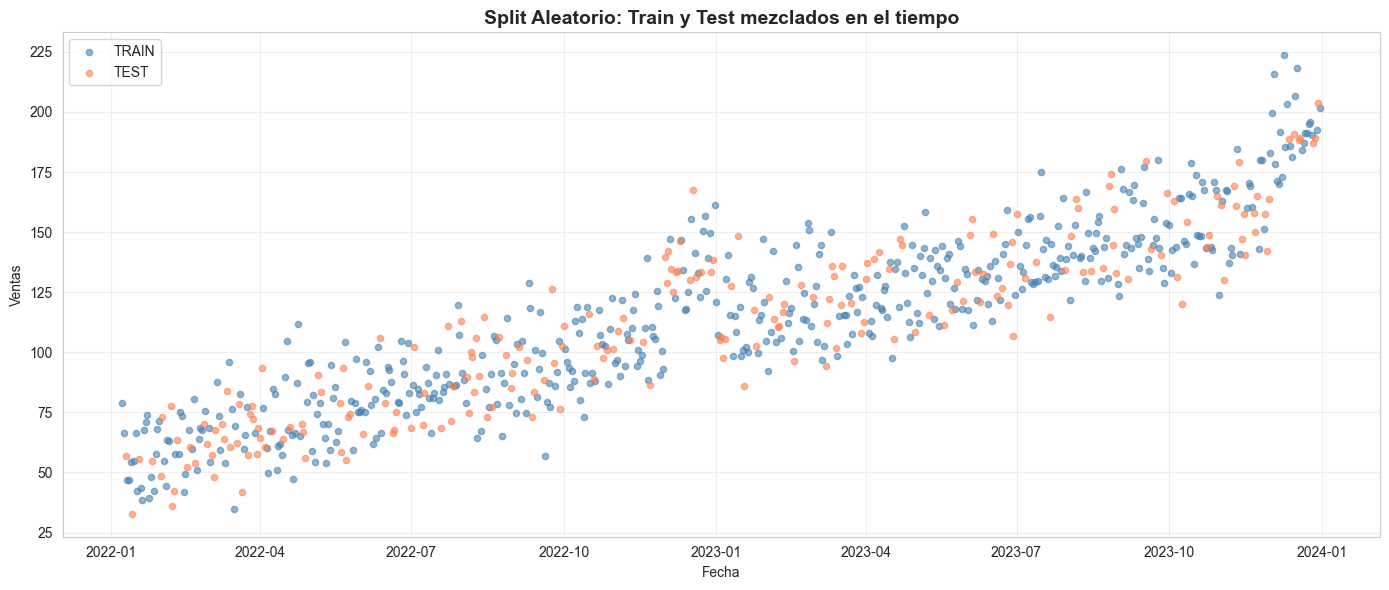

🔴 PROBLEMA: Los puntos de test (naranja) están mezclados con train (azul)
   El modelo 've el futuro' porque aprende de datos posteriores a algunos datos de test


In [6]:
# Visualizar qué datos están en train vs test (split aleatorio)
df_viz_wrong = df.copy()
df_viz_wrong['conjunto'] = 'train'
df_viz_wrong.loc[X_test_wrong.index, 'conjunto'] = 'test'

plt.figure(figsize=(14, 6))
for conjunto, color in [('train', 'steelblue'), ('test', 'coral')]:
    mask = df_viz_wrong['conjunto'] == conjunto
    plt.scatter(df_viz_wrong.loc[mask, 'fecha'], 
                df_viz_wrong.loc[mask, 'ventas'],
                c=color, label=conjunto.upper(), alpha=0.6, s=20)

plt.title('Split Aleatorio: Train y Test mezclados en el tiempo', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("🔴 PROBLEMA: Los puntos de test (naranja) están mezclados con train (azul)")
print("   El modelo 've el futuro' porque aprende de datos posteriores a algunos datos de test")

## 4. ✅ Enfoque CORRECTO: Split Temporal

### ¿Cómo se hace correctamente?

En datos temporales, debemos respetar el orden cronológico:
- **Train**: Primeros N% de los datos (datos más antiguos)
- **Test**: Últimos M% de los datos (datos más recientes)

**Ventaja**: El modelo solo aprende del pasado y predice el futuro, como ocurre en producción.

In [7]:
# Split temporal (CORRECTO)
# Usar los primeros 70% para train, últimos 30% para test
split_point = int(len(df) * 0.7)

X_train_correct = X.iloc[:split_point]
X_test_correct = X.iloc[split_point:]
y_train_correct = y.iloc[:split_point]
y_test_correct = y.iloc[split_point:]

fecha_train_end = df.iloc[split_point-1]['fecha']
fecha_test_start = df.iloc[split_point]['fecha']

print("Split Temporal (CORRECTO)")
print("="*50)
print(f"Train: {len(X_train_correct)} muestras (hasta {fecha_train_end.date()})")
print(f"Test:  {len(X_test_correct)} muestras (desde {fecha_test_start.date()})")

# Entrenar modelo
model_correct = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
model_correct.fit(X_train_correct, y_train_correct)

# Predicciones
y_pred_correct = model_correct.predict(X_test_correct)

# Métricas
mae_correct = mean_absolute_error(y_test_correct, y_pred_correct)
rmse_correct = np.sqrt(mean_squared_error(y_test_correct, y_pred_correct))
r2_correct = r2_score(y_test_correct, y_pred_correct)

print(f"\nMétricas en Test (Split Temporal):")
print(f"  MAE:  {mae_correct:.2f}")
print(f"  RMSE: {rmse_correct:.2f}")
print(f"  R²:   {r2_correct:.4f}")
print("\n✅ Estas métricas reflejan el desempeño REAL en producción")

Split Temporal (CORRECTO)
Train: 506 muestras (hasta 2023-05-28)
Test:  217 muestras (desde 2023-05-29)

Métricas en Test (Split Temporal):
  MAE:  21.95
  RMSE: 28.03
  R²:   -0.5295

✅ Estas métricas reflejan el desempeño REAL en producción


### Visualización del Split Correcto

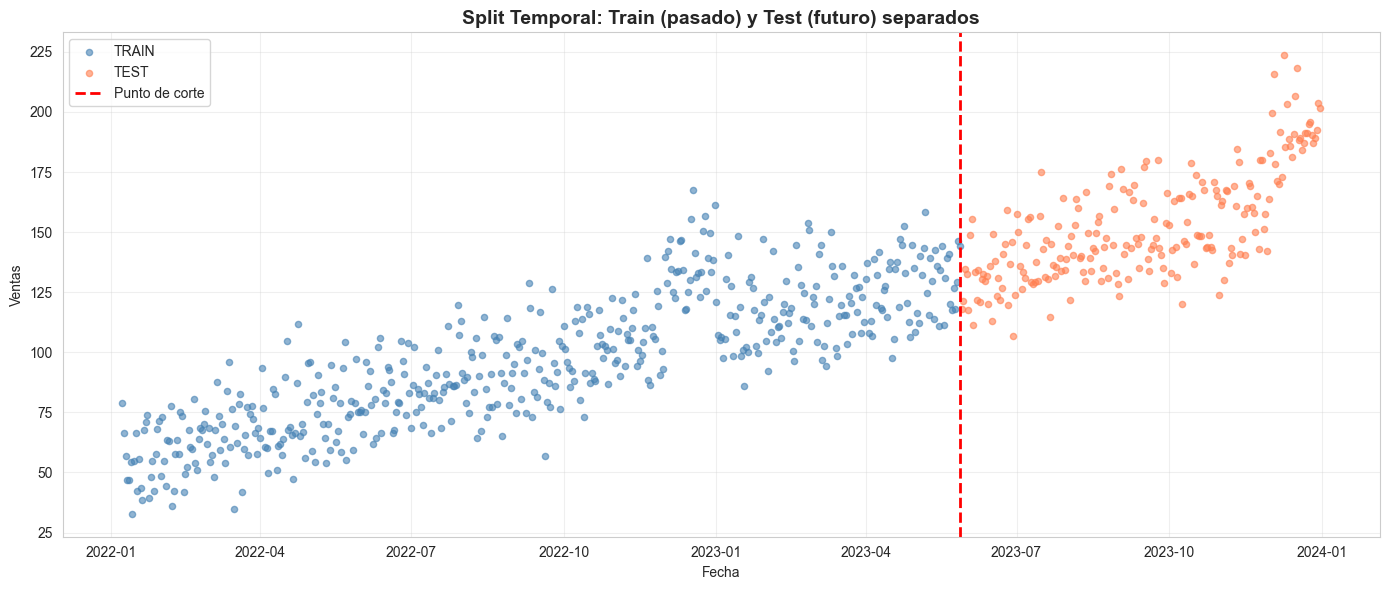

🟢 CORRECTO: Train (azul) contiene solo datos pasados
   Test (naranja) contiene solo datos futuros al entrenamiento


In [8]:
# Visualizar split temporal
df_viz_correct = df.copy()
df_viz_correct['conjunto'] = 'train'
df_viz_correct.iloc[split_point:, df_viz_correct.columns.get_loc('conjunto')] = 'test'

plt.figure(figsize=(14, 6))
for conjunto, color in [('train', 'steelblue'), ('test', 'coral')]:
    mask = df_viz_correct['conjunto'] == conjunto
    plt.scatter(df_viz_correct.loc[mask, 'fecha'], 
                df_viz_correct.loc[mask, 'ventas'],
                c=color, label=conjunto.upper(), alpha=0.6, s=20)

plt.axvline(x=fecha_train_end, color='red', linestyle='--', linewidth=2, label='Punto de corte')
plt.title('Split Temporal: Train (pasado) y Test (futuro) separados', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("🟢 CORRECTO: Train (azul) contiene solo datos pasados")
print("   Test (naranja) contiene solo datos futuros al entrenamiento")

## 5. Comparación de Resultados

Ahora comparemos las métricas de ambos enfoques.

In [9]:
# Tabla comparativa
comparison = pd.DataFrame({
    'Métrica': ['MAE', 'RMSE', 'R²'],
    'Split Aleatorio\n(INCORRECTO)': [mae_wrong, rmse_wrong, r2_wrong],
    'Split Temporal\n(CORRECTO)': [mae_correct, rmse_correct, r2_correct],
    'Diferencia (%)': [
        ((mae_correct - mae_wrong) / mae_wrong * 100),
        ((rmse_correct - rmse_wrong) / rmse_wrong * 100),
        ((r2_correct - r2_wrong) / r2_wrong * 100)
    ]
})

print("\nCOMPARACIÓN DE MÉTRICAS")
print("="*70)
print(comparison.to_string(index=False))
print("\n⚠️  El split aleatorio SOBREESTIMA el desempeño del modelo")
print("    En producción, el modelo tendrá el desempeño del split temporal")


COMPARACIÓN DE MÉTRICAS
Métrica  Split Aleatorio\n(INCORRECTO)  Split Temporal\n(CORRECTO)  Diferencia (%)
    MAE                      10.084379                   21.951777      117.681003
   RMSE                      12.542186                   28.029340      123.480496
     R²                       0.883580                   -0.529473     -159.923636

⚠️  El split aleatorio SOBREESTIMA el desempeño del modelo
    En producción, el modelo tendrá el desempeño del split temporal


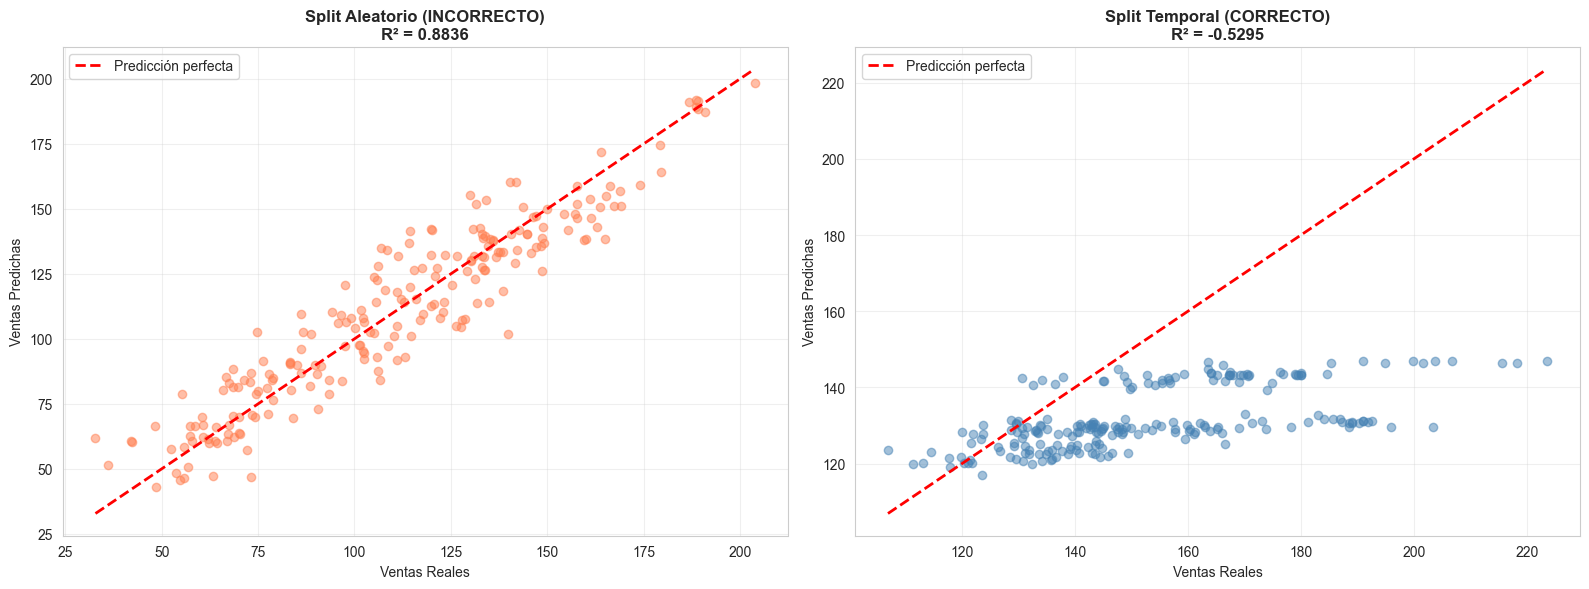

Observa que el R² es menor con el split temporal (más realista)


In [10]:
# Visualización de predicciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Split aleatorio
axes[0].scatter(y_test_wrong, y_pred_wrong, alpha=0.5, color='coral')
axes[0].plot([y_test_wrong.min(), y_test_wrong.max()], 
             [y_test_wrong.min(), y_test_wrong.max()], 
             'r--', linewidth=2, label='Predicción perfecta')
axes[0].set_xlabel('Ventas Reales')
axes[0].set_ylabel('Ventas Predichas')
axes[0].set_title(f'Split Aleatorio (INCORRECTO)\nR² = {r2_wrong:.4f}', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Split temporal
axes[1].scatter(y_test_correct, y_pred_correct, alpha=0.5, color='steelblue')
axes[1].plot([y_test_correct.min(), y_test_correct.max()], 
             [y_test_correct.min(), y_test_correct.max()], 
             'r--', linewidth=2, label='Predicción perfecta')
axes[1].set_xlabel('Ventas Reales')
axes[1].set_ylabel('Ventas Predichas')
axes[1].set_title(f'Split Temporal (CORRECTO)\nR² = {r2_correct:.4f}', 
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observa que el R² es menor con el split temporal (más realista)")

## 6. Predicciones en el Tiempo: Visualización Final

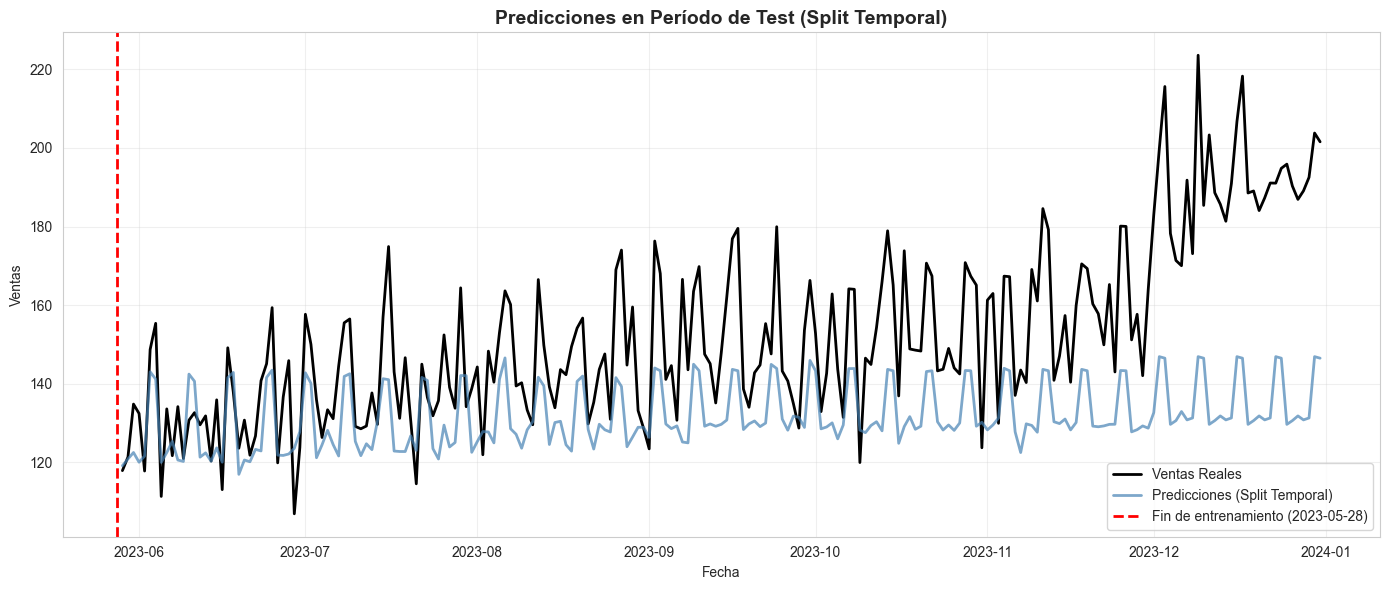

In [11]:
# Visualizar predicciones vs reales en el período de test (solo para split correcto)
df_test_viz = df.iloc[split_point:].copy()
df_test_viz['prediccion'] = y_pred_correct

plt.figure(figsize=(14, 6))
plt.plot(df_test_viz['fecha'], df_test_viz['ventas'], 
         label='Ventas Reales', linewidth=2, color='black')
plt.plot(df_test_viz['fecha'], df_test_viz['prediccion'], 
         label='Predicciones (Split Temporal)', linewidth=2, color='steelblue', alpha=0.7)
plt.axvline(x=fecha_train_end, color='red', linestyle='--', linewidth=2, 
            label=f'Fin de entrenamiento ({fecha_train_end.date()})')
plt.title('Predicciones en Período de Test (Split Temporal)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Uso de TimeSeriesSplit de Scikit-learn

Para validación cruzada en datos temporales, sklearn ofrece `TimeSeriesSplit`.

In [12]:
from sklearn.model_selection import TimeSeriesSplit

# Crear time series split con 5 folds
tscv = TimeSeriesSplit(n_splits=5)

print("TimeSeriesSplit: Validación Cruzada Temporal")
print("="*70)

scores = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train_cv = X.iloc[train_idx]
    X_test_cv = X.iloc[test_idx]
    y_train_cv = y.iloc[train_idx]
    y_test_cv = y.iloc[test_idx]
    
    # Entrenar y evaluar
    model_cv = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=8)
    model_cv.fit(X_train_cv, y_train_cv)
    score = model_cv.score(X_test_cv, y_test_cv)
    scores.append(score)
    
    print(f"Fold {fold}: Train size = {len(train_idx)}, Test size = {len(test_idx)}, R² = {score:.4f}")

print(f"\nR² promedio: {np.mean(scores):.4f} (± {np.std(scores):.4f})")
print("\n✅ TimeSeriesSplit respeta el orden temporal en cada fold")

TimeSeriesSplit: Validación Cruzada Temporal
Fold 1: Train size = 123, Test size = 120, R² = 0.0076
Fold 2: Train size = 243, Test size = 120, R² = -0.8329
Fold 3: Train size = 363, Test size = 120, R² = -0.1545
Fold 4: Train size = 483, Test size = 120, R² = 0.0625
Fold 5: Train size = 603, Test size = 120, R² = -0.4860

R² promedio: -0.2807 (± 0.3358)

✅ TimeSeriesSplit respeta el orden temporal en cada fold


## Conclusiones

### ❌ Split Aleatorio en Datos Temporales:
1. Genera **data leakage**: el modelo "ve el futuro"
2. Produce métricas **artificialmente optimistas**
3. No refleja el **desempeño real en producción**
4. Puede llevar a decisiones erróneas sobre el modelo

### ✅ Split Temporal (Correcto):
1. Respeta la **naturaleza secuencial** de los datos
2. El modelo aprende del **pasado** y predice el **futuro**
3. Métricas reflejan el **desempeño real esperado**
4. Es la forma correcta de evaluar modelos en producción

### Regla de Oro:

> **Si tus datos tienen fecha/hora, SIEMPRE usa split temporal**

### Casos de Uso:
- Predicción de ventas
- Forecasting de demanda
- Predicción de precios de acciones
- Detección de anomalías en sistemas
- Cualquier problema con componente temporal

### Herramientas Recomendadas:
- **Split manual** con `.iloc[]` basado en fecha
- **`TimeSeriesSplit`** para validación cruzada temporal
- **`GroupShuffleSplit`** si necesitas agrupar por períodos de tiempo